# Lesson 01. Part 4. Universal linear equation

Let's try to build a universal linear equation: ```y = kx + b```. The thing is that we don't need to train a neaural network for this. It's much easier to achieve it with a simple math. How can we do this?

```k``` parameter in the equation is a slope or how the difference in change in ```y``` relates to the change in difference of ```x```. Between 2 points, the formula is: ```k = (y1-y2)/(x1-x2)```. If we have more than 1 point, we may say that the result ```k(result)``` is the average value of all slopes which connect to nearest points:

```k = ((y1-y2)/(x1-x2) + (y2-y3)/(x2-x3) + ... (y(n-1)-y(n))/(x(n-1)-x(n))) / N ```

To make this formula more accurate, we may count a weighted average value, where a points with a longer distance have a bigger weight

## Preparation

In [43]:
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [44]:
# get device for training (cpu, cuda or mps)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"{device} device is used")

mps device is used


In [45]:
# display settings
torch.set_printoptions(precision=2, sci_mode=False)

## Sample data

The input for our model will be a set of ```(x,y)``` points. As a result, it needs to calculate and return ```k``` and ```b``` values from the equation ```y = kx + b```

Let's create some helper-functions to generate sample data

In [46]:
# let's create a function to calculate y for the equation y = kx + b
def calculate_y(x, k, b, bias):
    y = k * x + b + bias * random.random()
    return y

def generate_random_value(min_value, max_value):
    return random.random() * (max_value - min_value) + min_value

def generate_linear_values(x_min, x_max, amount, k, b, bias=0):
    x = torch.rand(amount) * (x_max - x_min) + x_min
    y = x.clone().apply_(lambda x: calculate_y(x=x, k=k, b=b, bias=bias))
    return (x,y)

Let's check how functions above work

k =  -7.086614897917394
b =  -0.9014599097195735
x =  tensor([-7.77,  6.32, -4.75, -0.32,  3.53,  5.08, -4.75, -9.14, -5.84, -7.64,
        -7.57,  4.71,  4.24,  5.75, -1.63,  8.03])
y =  tensor([ 54.14, -45.67,  32.75,   1.38, -25.92, -36.89,  32.73,  63.89,  40.48,
         53.23,  52.72, -34.29, -30.92, -41.66,  10.68, -57.79])


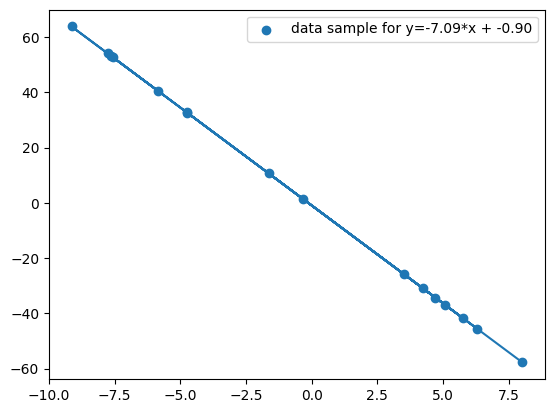

In [47]:
# settings
model_input_points = 16

min_x = -10
max_x = 10

min_k = -10
max_k = 10

min_b = -10
max_b = 10

# generation
random.seed(100)         # fix random values (debug only)
torch.manual_seed(100)   # fix random values (debug only)

k = generate_random_value(min_k, max_k)
b = generate_random_value(min_b, max_b)

(x,y) = generate_linear_values(
    x_min=min_x,
    x_max=max_x,
    amount=model_input_points,
    k=k,
    b=b,
)

print('k = ', k)
print('b = ', b)
print('x = ', x)
print('y = ', y)

plt.plot(x, y)
plt.scatter(x, y, label='data sample for y={:.2f}*x + {:.2f}'.format(k, b))
plt.legend()
plt.show()

## Let's do some math

At this point of time we have a list of points. Let's try to calculate the slope ```k``` and and shift ```b``` based on these points

In [48]:
def calculate_slope(x,y):
    # calculate x and y changes
    x_difference = x - torch.roll(x, -1)
    y_difference = y - torch.roll(y, -1)

    # calculate slope and distance
    slopes = y_difference / x_difference
    distance = torch.sqrt(x_difference ** 2 + y_difference ** 2)

    # ignore last distance (it goes from the first to the last point)
    distance[len(distance)-1] = .0

    # calculate weighted slope
    k = torch.sum(torch.mul(slopes, distance)) / torch.sum(distance)

    return k

calculated_k = calculate_slope(x,y)
print('calculated_k =', calculated_k)

calculated_k = tensor(-7.09)


Knowing ```k``` we can easily calculate ```b``` using formula ```b = y - kx```

In [49]:
def calculate_shift(x,y,k):
    b_values = y - torch.full((1, len(x)), k.item()) * x
    calculated_b = torch.mean(b_values)

    return calculated_b

calculated_b = calculate_shift(x,y,calculated_k)
print('calculated_b = ', calculated_b)

calculated_b =  tensor(-0.90)


It can be seen that both ```k``` and ```b``` values are calculated properly using only math. The total function to calculate this values will be:

In [50]:
def calculate_linear_params(x,y):
    k = calculate_slope(x,y)
    b = calculate_shift(x,y,k)

    return (k,b)

In [51]:
calculate_linear_params(x,y)

(tensor(-7.09), tensor(-0.90))

## Let's apply this function for other datasets

calculated (k,b) (tensor(2.07), tensor(-0.90))


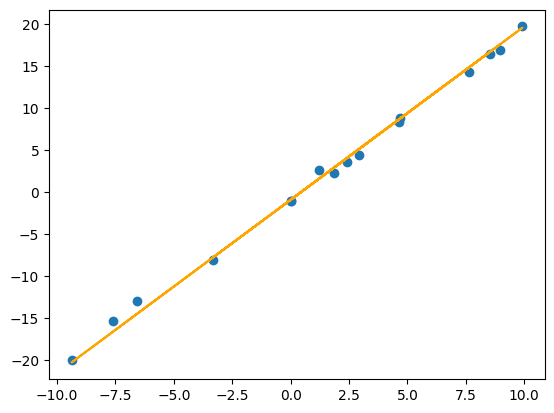

In [52]:
random.seed(200)         # fix random values (debug only)
torch.manual_seed(200)   # fix random values (debug only)

(test_x, test_y) = generate_linear_values(
    x_min=min_x,
    x_max=max_x,
    amount=model_input_points,
    k=2,
    b=-1.5,
    bias=2
)

(result_k, result_b) = calculate_linear_params(test_x, test_y)
print('calculated (k,b)', (result_k, result_b))

plt.plot(
    test_x,
    test_x.clone().apply_(lambda x: result_k * x + result_b),
    color='orange'
)
plt.scatter(test_x, test_y)
plt.show()

The result looks good. We haven't covered cases where the line is strictly vertical or horizontal, and the case where points are ordered randomly, but it's not critical for this lesson